In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import timeit
import re
import copy as cp

from preprocessing.data_norm import *
from preprocessing.make_idx import *
from preprocessing.make_team_v2 import *
from preprocessing.train_v2 import *


In [2]:
# Set up for neural network training
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device = torch.device('cpu')
print_every = 100
print('Using device:', device)


Using device: cpu


In [3]:
# Initializing team names and abbreviations for later use
teamName = ["Atlanta Hawks", "Boston Celtics", "Brooklyn Nets", "Charlotte Bobcats", "Charlotte Hornets",
            "Chicago Bulls", "Cleveland Cavaliers", "Dallas Mavericks", "Denver Nuggets", "Detroit Pistons",
            "Golden State Warriors", "Houston Rockets", "Indiana Pacers", "Los Angeles Clippers", "Los Angeles Lakers",
            "Memphis Grizzlies", "Miami Heat", "Milwaukee Bucks", "Minnesota Timberwolves", "New Jeresy Nets",
            "New Orleans Hornets", "New Orleans Pelicans", "New York Knicks", "Oklahoma City Thunder", "Orlando Magic",
            "Philadelphia 76ers", "Phoenix Suns", "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs",
            "Seattle SuperSonics", "Toronto Raptors", "Utah Jazz", "Vancouver Grizzlies", "Washington Bullets",
            "Washington Wizards"]
Abbr = ["ATL", "BOS", "BRK", "CHA", "CHO", "CHI", "CLE", "DAL", "DEN", "DET", "GSW", "HOU", "IND", "LAC", "LAL", "MEM",
        "MIA", "MIL", "MIN", "NJN", "NOH", "NOP", "NYK", "OKC", "ORL", "PHI", "PHO", "POR", "SAC", "SAS", "SEA", "TOR",
        "UTA", "VAN", "WSB", "WAS"]
teamName2019 = ["Atlanta Hawks", "Boston Celtics", "Brooklyn Nets", "Charlotte Hornets",
            "Chicago Bulls", "Cleveland Cavaliers", "Dallas Mavericks", "Denver Nuggets", "Detroit Pistons",
            "Golden State Warriors", "Houston Rockets", "Indiana Pacers", "Los Angeles Clippers", "Los Angeles Lakers",
            "Memphis Grizzlies", "Miami Heat", "Milwaukee Bucks", "Minnesota Timberwolves", "New Orleans Pelicans", 
            "New York Knicks", "Oklahoma City Thunder", "Orlando Magic", "Philadelphia 76ers", "Phoenix Suns", 
            "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs", "Toronto Raptors", 
            "Utah Jazz", "Washington Wizards"]
Abbr2019 = ["ATL", "BOS", "BRK", "CHO", "CHI", "CLE", "DAL", "DEN", "DET", "GSW", "HOU", "IND", "LAC", "LAL", "MEM",
        "MIA", "MIL", "MIN", "NOP", "NYK", "OKC", "ORL", "PHI", "PHO", "POR", "SAC", "SAS", "TOR", "UTA", "WAS"]
# Indices of used advanced player metrics (each value corresponds to the index of the column)
need_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 19, 20]


In [4]:
# 25 training years, 5 testing years, optional validation years
trainYear = 25
startYear_train = 1989
validationYear = 0
startYear_validation = startYear_train + trainYear
testYear = 5
startYear_test = startYear_validation + validationYear

# Initialization for training set
player_list_train = [0] * trainYear
winrate_list_train = [0] * trainYear
data_list_train = [0] * trainYear
team_idx_train = [0] * trainYear
data_input_train = [0] * trainYear
loader_train = {}
loader_validation = {}
loader_test = {}

# Creating training data
for index in range(trainYear):
    # Read stats
    playerstats_train = "Player_Data/AvgPlayerStats" + str(index + startYear_train) + ".csv"
    teamstats_train = "Team_Data/TeamStats" + str(index + startYear_train) + ".csv"
    # Convert type
    player_list_train[index] = pd.read_csv(playerstats_train, header=None).values
    winrate_list_train[index] = pd.read_csv(teamstats_train, header=None).values
    # Discard useless columns
    data_list_train[index] = player_list_train[index][:, 4:]
    # Normalization
    data_list_train[index] = data_norm(data_list_train[index])
    # Make abbreviations
    team_idx_train[index] = make_idx(winrate_list_train[index], Abbr, teamName)
    # Put players in same team together
    data_input_train[index] = make_team(player_list_train[index], data_list_train[index], team_idx_train[index],
                                        str(index + startYear_train), device, dtype, need_idx)
    # Put data into dictionary
    loader_train = dict(loader_train, **data_input_train[index])

# Initialization for validation set
player_list_validation = [0] * validationYear
winrate_list_validation = [0] * validationYear
data_list_validation = [0] * validationYear
team_idx_validation = [0] * validationYear
data_input_validation = [0] * validationYear

# Creating validation data
for index in range(validationYear):
    # Read stats
    playerstats_validation = "Player_Data/AvgPlayerStats" + str(index + startYear_validation) + ".csv"
    teamstats_validation = "Team_Data/TeamStats" + str(index + startYear_validation) + ".csv"
    # Convert type
    player_list_validation[index] = pd.read_csv(playerstats_validation, header=None).values
    winrate_list_validation[index] = pd.read_csv(teamstats_validation, header=None).values
    # Discard useless columns
    data_list_validation[index] = player_list_validation[index][:, 4:]
    # Normalization
    data_list_validation[index] = data_norm(data_list_validation[index])
    # Make abbreviations
    team_idx_validation[index] = make_idx(winrate_list_validation[index], Abbr, teamName)
    # Put players in same team together
    data_input_validation[index] = make_team(player_list_validation[index], data_list_validation[index],
                                             team_idx_validation[index], str(index + startYear_validation), device,
                                             dtype, need_idx)
    # Put data into dictionary
    loader_validation = dict(loader_validation, **data_input_validation[index])

# Initialization for testing data
player_list_test = [0] * testYear
winrate_list_test = [0] * testYear
data_list_test = [0] * testYear
team_idx_test = [0] * testYear
data_input_test = [0] * testYear

# Creating testing data
for index in range(testYear):
    # Read stats
    playerstats_test = "Player_Data/AvgPlayerStats" + str(index + startYear_test) + ".csv"
    teamstats_test = "Team_Data/TeamStats" + str(index + startYear_test) + ".csv"
    # Convert type
    player_list_test[index] = (pd.read_csv(playerstats_test, header=None)).values
    winrate_list_test[index] = (pd.read_csv(teamstats_test, header=None)).values
    # Discard useless columns
    data_list_test[index] = player_list_test[index][:, 4:]
    # Normalization
    data_list_test[index] = data_norm(data_list_test[index])
    # Make abbreviations
    team_idx_test[index] = make_idx(winrate_list_test[index], Abbr, teamName)
    # Put players in same team together
    data_input_test[index] = make_team(player_list_test[index], data_list_test[index], team_idx_test[index],
                                       str(index + startYear_test), device, dtype, need_idx)

# Initialization for 2019 data
player_list_2019 = [0]
winrate_list_2019 = [0]
data_list_2019 = [0]
team_idx_2019 = [0]
data_input_2019 = [0]

# Creating 2019 data
# Read stats
playerstats_2019 = "Player_Data/AvgPlayerStats2019.csv"
teamstats_2019 = "Team_Data/TeamStats2019.csv"
# Convert type
player_list_2019[0] = (pd.read_csv(playerstats_2019, header=None)).values
winrate_list_2019[0] = (pd.read_csv(teamstats_2019, header=None)).values
# Discard useless columns
data_list_2019[0] = player_list_2019[0][:, 4:]
# Normalization
data_list_2019[0] = data_norm(data_list_2019[0])
# Make abbreviations
team_idx_2019[0] = make_idx(winrate_list_2019[0], Abbr2019, teamName2019)
# Put players in same team together
data_input_2019[0] = make_team(player_list_2019[0], data_list_2019[0], team_idx_2019[0],
                                   str(2019), device, dtype, need_idx)


In [6]:
#Loads previously ran modelmodel = torch.load('Models_Figures\Model_final.fit')


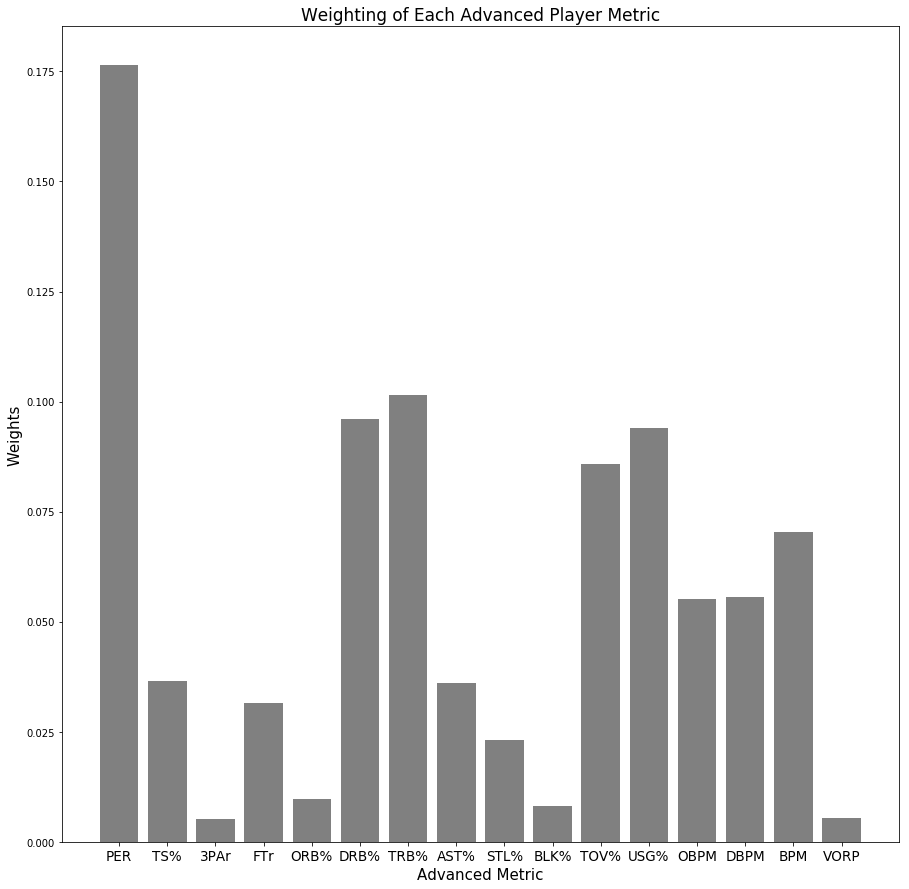

In [12]:
# Visualization of the weights
data_name = ['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OBPM',
             'DBPM', 'BPM', 'VORP']
weight = abs(model.state_dict()['0.0.weight'][0])
bar_width = 0.8
x_axis = np.arange(len(data_name))
y_axis_1 = tuple(weight[:16])
poly1 = plt.bar(x_axis, y_axis_1, bar_width, color='0.50')
plt.xticks(x_axis, data_name, fontsize=13.5)
plt.title('Weighting of Each Advanced Player Metric', fontsize=17)
plt.xlabel('Advanced Metric', fontsize=15)
plt.ylabel('Weights', fontsize=15)
plt.gcf().set_size_inches(15, 15)


E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
E:\Anaconda\envs\cs231n\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensure

Loss of 2014 : tensor(0.1280, grad_fn=<ThAddBackward>)
Loss of 2015 : tensor(0.2145, grad_fn=<ThAddBackward>)
Loss of 2016 : tensor(0.2069, grad_fn=<ThAddBackward>)
Loss of 2017 : tensor(0.1202, grad_fn=<ThAddBackward>)
Loss of 2018 : tensor(0.1893, grad_fn=<ThAddBackward>)


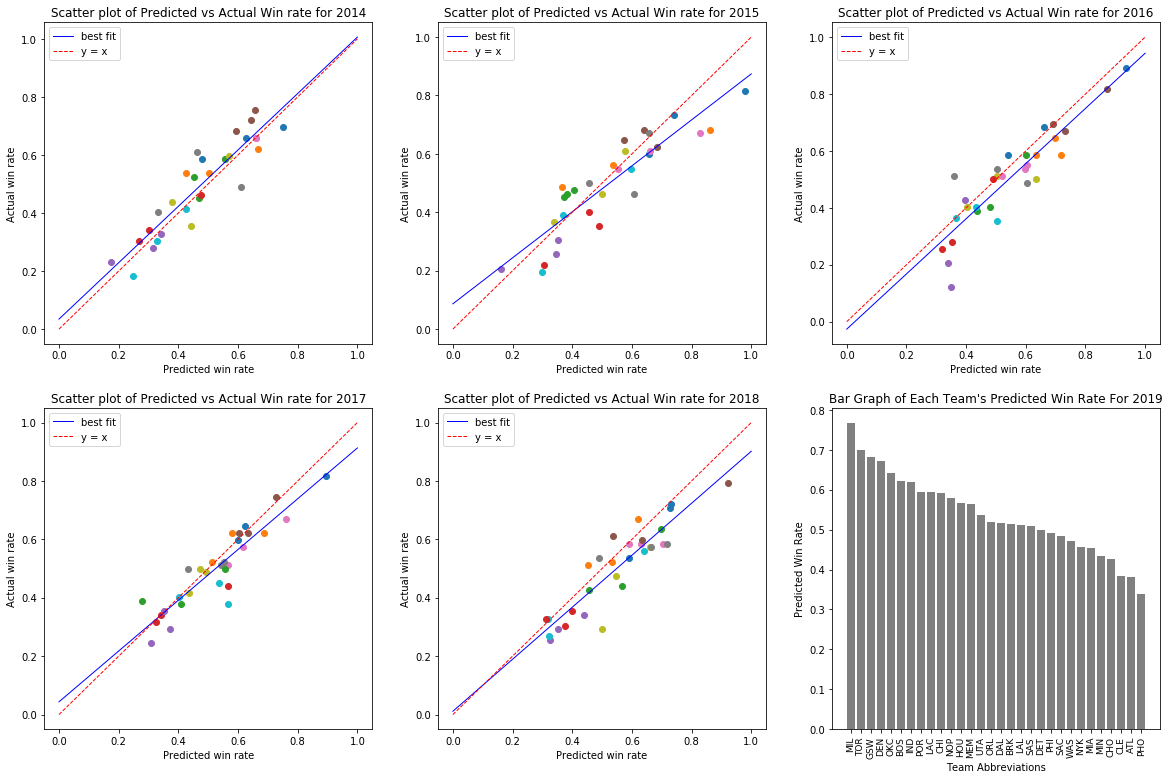

<Figure size 432x288 with 0 Axes>

In [8]:
# Display testing set results

# Initializing variables
x = []
y = []
loss = 0
pre_dic = [0] * 5
for i in range(5):
    x = []
    y = []
    loss = 0
    pre_dic[i] = {}
    # Obtain predictions
    for t, content in data_input_test[i].items():
        plt.subplot(2, 3, i + 1)
        PER_C = model(content[0])
        # Loss is the mean square error        
        win_rate = sum(PER_C)
        plt.scatter(win_rate[0].data, content[1][0].data)
        x.append(win_rate[0].data)
        y.append(content[1][0].data)
        loss += (win_rate[0] - content[1][0].data) ** 2
        pre_dic[i][t] = win_rate[0].data

    print("Loss of", i+2014,":", loss)
    # Scatter plots of predictions
    z1 = np.polyfit(x, y, 1)
    p1 = np.poly1d(z1)
    x = np.linspace(0, 1, 100)
    y = z1[0] * x + z1[1]
    l1 = plt.plot(x, y, color='blue', linewidth=1.0, label='line')
    x = np.linspace(0, 1, 100)
    y = x
    l2 = plt.plot(x, y, color='red', linewidth=1.0, linestyle='--', label='line')
    plt.gcf().set_size_inches(10, 10)
    plt.gcf().set_size_inches(20, 13)
    plt.ylabel("Actual win rate")
    plt.xlabel("Predicted win rate")
    plt.title("Scatter plot of Predicted vs Actual Win rate for " + str(i + 2014))
    plt.legend(labels=['best fit', 'y = x'], loc='best')
# Prediction for 2019 Season
# Initialize variables
y2019 = []
loss2019 = 0
pre_dic2019 = [0]
pre_dic2019[0] = {}
# Obtain predictions
win_list2019 = []
for t, content in data_input_2019[0].items():
    PER_C2019 = model(content[0])
    winrates2019 = PER_C2019.detach().numpy()
    win_list2019.append([t,np.sum(winrates2019)])
    win_rate2019 = sum(PER_C2019)
    pre_dic2019[0][t] = win_rate2019[0].data
win_list2019.sort(key=lambda x: x[0])
xaxis = []
for i in range(len(win_list2019)):
    xaxis.append(win_list2019[i][1]*50/82)
final_list = list(zip(xaxis,Abbr2019))
final_list.sort(key=lambda x: x[0])
final_list = list(reversed(final_list))
x_axis2019, y_axis2019 = [], []
for i in range(len(final_list)):
    x_axis2019.append(final_list[i][1])
    y_axis2019.append(final_list[i][0])  
plt.subplot(2,3,6)
plt.xticks(rotation='vertical',fontsize=9)
plt.xlabel('Team Abbreviations')
plt.ylabel('Predicted Win Rate')
plt.title("Bar Graph of Each Team's Predicted Win Rate For 2019")
bar = plt.bar(x_axis2019, y_axis2019,color='0.50')    
plt.show()
plt.savefig('Predictions.png')

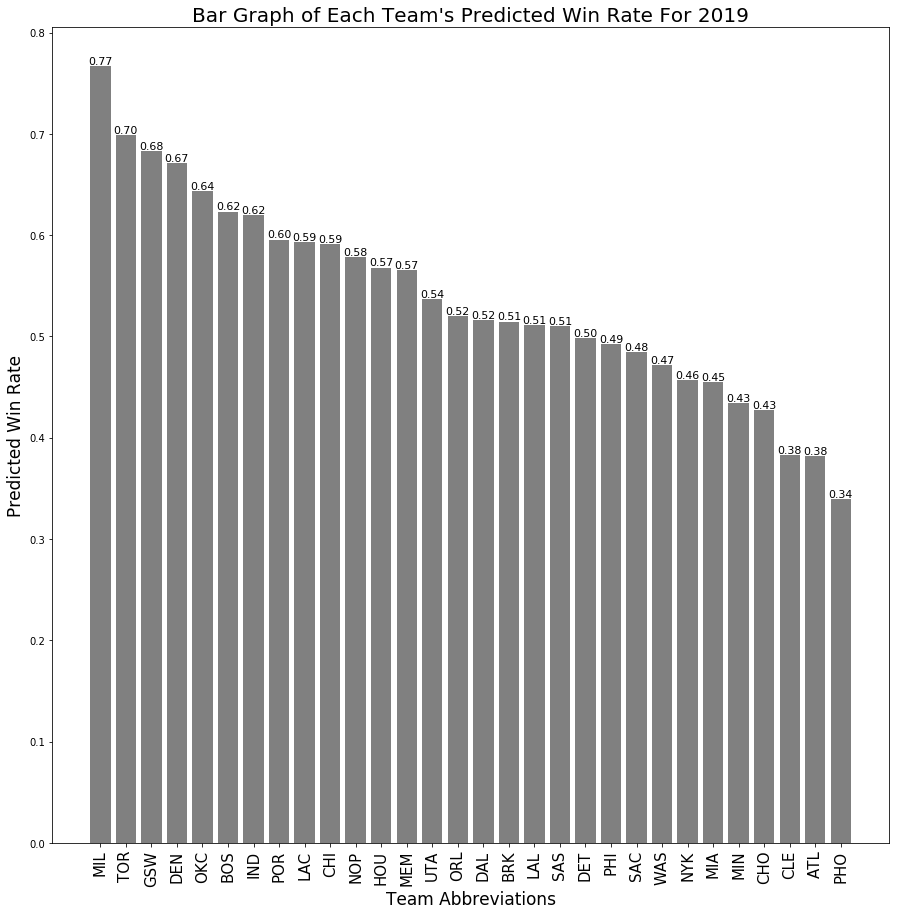

In [9]:
plt.xticks(rotation='vertical', fontsize=15)
plt.xlabel('Team Abbreviations', fontsize=17)
plt.ylabel('Predicted Win Rate', fontsize=17)
plt.title("Bar Graph of Each Team's Predicted Win Rate For 2019", fontsize=20)
bar = plt.bar(x_axis2019, y_axis2019,color='0.50')
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, '%.2f' % float(height), ha='center', va='bottom', fontsize=11)
plt.gcf().set_size_inches(15, 15)

plt.show()


In [10]:
# Recommend which team to bet

# Initialize variables
betting_data = [0] * testYear
prediction = []
ML_stg = dict()
money_visit_dic = {0: [], 0: [], 0: [], 0: [], 0: []}
money_home_dic = {0: [], 0: [], 0: [], 0: [], 0: []}
result_pre_dic = {0: [], 0: [], 0: [], 0: [], 0: []}
total_money_home = [[0], [0], [0], [0], [0]]
total_money_visit = [[0], [0], [0], [0], [0]]

# Obtain betting odds data for use
for index in range(testYear):
    betting_file = "Betting_Data/bettingOdds" + str(startYear_test + index) + ".csv"
    betting_data[index] = (pd.read_csv(betting_file, header=None)).values
    prefix = 'Prediction_Result/Prediction_Result'
    version=str(startYear_test + index)
    result=prefix+version+'.txt'
    # Strategy based on predictoin result
    ML_stg[str(startYear_test + index)] = []
    money_visit_dic[str(index + startYear_test)] = []
    money_home_dic[str(index + startYear_test)] = []
    result_pre_dic[str(index + startYear_test)] = []
    with open(result, 'w') as part:
        for i in range(len(betting_data[index])):
            # Get abbr for each team : 'teamname' + 'year'
            try:
                home_position = teamName.index((betting_data[index][i][0]))
                home_Abbr = Abbr[home_position] + str(startYear_test + index)
                visiting_position = teamName.index((betting_data[index][i][1]))
                visiting_Abbr = Abbr[visiting_position] + str(startYear_test + index)
            except:
                pass
            # Get the overall win rate for each team using the model we trained
            if (home_Abbr in pre_dic[index] and visiting_Abbr in pre_dic[index]):
                home_winrate = pre_dic[index][home_Abbr]
                visiting_winrate = pre_dic[index][visiting_Abbr]
                home_odds = betting_data[index][i][2]
                visiting_odds = betting_data[index][i][3]
                # Predicted win rate for current game
                home_winrate_cg = (home_winrate) / (home_winrate + visiting_winrate)
                visiting_winrate_cg = (visiting_winrate) / (home_winrate + visiting_winrate)
                # Predicted result of current game
                if home_winrate_cg > visiting_winrate_cg:
                    result_cg = 'Home'
                else:
                    result_cg = 'Visiting'
                result_pre_dic[str(index + startYear_test)].append(result_cg)

                # Calculate earning based on different possible outcomes
                if home_odds > 0:
                    money_home_win = home_winrate * (home_odds + 100)
                    money_home_dic[str(index + startYear_test)].append(money_home_win)
                    money_visit_win = visiting_winrate * (100 * 100 / visiting_odds + 100)
                    money_visit_dic[str(index + startYear_test)].append(money_visit_win)
                else:
                    if visiting_odds > 0:
                        money_home_win = home_winrate * (100 * 100 / home_odds + 100)
                        money_home_dic[str(index + startYear_test)].append(money_home_win)
                        money_visit_win = visiting_winrate * (visiting_odds + 100)
                        money_visit_dic[str(index + startYear_test)].append(money_visit_win)
                    else:
                        money_home_win = home_winrate * (100 * 100 / home_odds + 100)
                        money_home_dic[str(index + startYear_test)].append(money_home_win)
                        money_visit_win = visiting_winrate * (100 * 100 / visiting_odds + 100)
                        money_visit_dic[str(index + startYear_test)].append(money_visit_win)

                # Make decision based on potential earnings
                if money_home_win >= money_visit_win:
                    decision = 'Home'
                else:
                    decision = 'Visiting'
                ML_stg[str(startYear_test + index)].append(decision)

                # Print result to a text file
                result = 'Match: ' + visiting_Abbr + ' @ ' + home_Abbr + ' | ' + 'Win Prob: ' + str("%.3f" %np.array(
                    visiting_winrate_cg)) + ' vs ' + str("%.3f" %np.array(home_winrate_cg)) + ' | ' + 'Odds: ' + str(
                    visiting_odds) + ' to ' + str(home_odds) + ' | ' + 'Recommendation: ' + decision + '\n'
                part.write(result)
# Strategy evaluation
money_visit_dic.pop(0)
money_home_dic.pop(0)
gain_ML = 0
num_games = 0  # Keep track of how many games we bet on
for year in range(startYear_test, testYear + startYear_test):
    resultfile = "Game_Data/GameResults" + str(year) + ".csv"
    result_data = (pd.read_csv(resultfile)).values
    lower_len = min(len(result_data), len(ML_stg[str(year)]))
    for i in range(lower_len):
        num_games += 1
        if ML_stg[str(year)][i] == result_data[i][2]:
            if ML_stg[str(year)][i] == 'Visiting':
                gain_ML += money_visit_dic[str(year)][i]
            else:
                gain_ML += money_home_dic[str(year)][i]
print("Model: ", gain_ML)

# Consider random strategy
gain_rand = 0
for year in range(startYear_test, testYear + startYear_test):
    resultfile = "Game_Data/GameResults" + str(year) + ".csv"
    result_data = (pd.read_csv(resultfile, header=None)).values
    lower_len = min(len(result_data), len(ML_stg[str(year)]))
    for i in range(lower_len):
        decision = np.random.randint(0, 2)  # 0 choose home, 1 choose visiting   
        if decision == 0 and result_data[i][2] == 'Home':
            gain_rand += money_home_dic[str(year)][i]
        if decision == 1 and result_data[i][2] == 'Visiting':
            gain_rand += money_visit_dic[str(year)][i]
print("Pick Random: ", gain_rand)

# Consider greedy strategy
# 1. Always bet on the lowest negative odds
gain_gdy_neg = 0
for year in range(startYear_test, testYear + startYear_test):
    resultfile = "Game_Data/GameResults" + str(year) + ".csv"
    result_data = (pd.read_csv(resultfile, header=None)).values
    betting_file = "Betting_Data/bettingOdds" + str(year) + ".csv"
    betting_data = (pd.read_csv(betting_file, header=None)).values
    len_com = min(len(money_visit_dic[str(year)]), len(result_data))
    for i in range(len_com):
        two_odds = [betting_data[i][2], betting_data[i][3]]
        if two_odds[0] < 0 and two_odds[1] > 0:
            decision = 0  #Bet on visiting
        elif two_odds[0] < 0 and two_odds[1] < 0:
            if abs(two_odds[0] > two_odds[1]):
                decision = 0
            else:
                decision = 1  #Bet on home
        else:
            decision = 1
        if decision == 0 and result_data[i][2] == 'Visiting':
            gain_gdy_neg += money_visit_dic[str(year)][i]
        if decision == 1 and result_data[i][2] == 'Home':
            gain_gdy_neg += money_home_dic[str(year)][i]
print("Greedy (Neg): ", gain_gdy_neg)

# 2. Always bet on the highest positive odds
gain_gdy_pos = 0
for year in range(startYear_test, testYear + startYear_test):
    resultfile = "Game_Data/GameResults" + str(year) + ".csv"
    result_data = (pd.read_csv(resultfile, header=None)).values
    betting_file = "Betting_Data/bettingOdds" + str(year) + ".csv"
    betting_data = (pd.read_csv(betting_file, header=None)).values
    len_com = min(len(money_visit_dic[str(year)]), len(result_data))
    for i in range(len_com):
        two_odds = [betting_data[i][2], betting_data[i][3]]
        if two_odds[0] < 0 and two_odds[1] > 0:
            decision = 1  #Bet on home
        elif two_odds[0] < 0 and two_odds[1] < 0:
            if abs(two_odds[0] > two_odds[1]):
                decision = 1
            else:
                decision = 0
        else:
            decision = 0  #Bet on visiting
        if decision == 0 and result_data[i][2] == 'Visiting':
            gain_gdy_pos += money_visit_dic[str(year)][i]
        elif decision == 0 and result_data[i][2] == 'Home':
            gain_gdy_pos += money_home_dic[str(year)][i]
        elif decision == 1 and result_data[i][2] == 'Home':
            gain_gdy_pos += money_home_dic[str(year)][i]

print("Greedy (Pos): ", gain_gdy_pos)

# Consider always betting on the predicted winning team regardless of odds
gain_win = 0
for year in range(startYear_test, testYear + startYear_test):
    resultfile = "Game_Data/GameResults" + str(year) + ".csv"
    result_data = (pd.read_csv(resultfile, header=None)).values
    pre_result = result_pre_dic[str(year)]
    lower_len = min(len(money_visit_dic[str(year)]), len(result_data))
    for i in range(lower_len):
        if pre_result == 'Visiting':
            decision = 0
        else:
            decision = 1
        if decision == 0 and result_data[i][2] == 'Visiting':
            gain_win += money_visit_dic[str(year)][i]
        if decision == 1 and result_data[i][2] == 'Home':
            gain_win += money_home_dic[str(year)][i]
print("Pick Winner Only: ", gain_win)


Model:  tensor(486741.7812)
Pick Random:  tensor(297924.2500)
Greedy (Neg):  tensor(446718.1875)
Greedy (Pos):  tensor(297883.0938)
Pick Winner Only:  tensor(246854.1719)


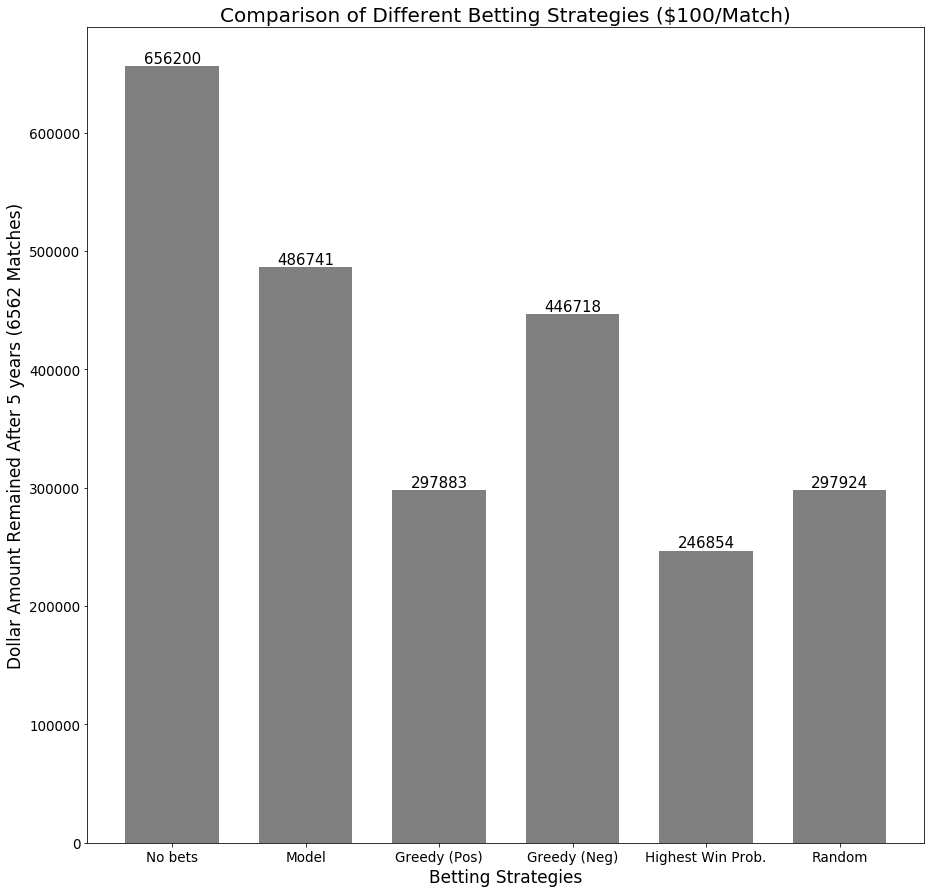

In [14]:
gain = [num_games * 100, gain_ML, gain_gdy_pos, gain_gdy_neg, gain_win, gain_rand]
method_name = ['No bets', 'Model', 'Greedy (Pos)', 'Greedy (Neg)', 'Highest Win Prob.', 'Random']
bar_width = 0.7
x_axis = np.arange(len(gain))
y_axis = tuple(gain)
fig, ax = plt.subplots()
poly = ax.bar(x_axis, y_axis, bar_width, color='0.50')
plt.title('Comparison of Different Betting Strategies ($100/Match)', fontsize=20)
plt.xlabel('Betting Strategies', fontsize=17)
plt.ylabel('Dollar Amount Remained After 5 years (6562 Matches)', fontsize=17)
plt.xticks(x_axis, method_name, fontsize=13.5)
for rect in poly:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=15)
plt.yticks(fontsize=13.5)
plt.gcf().set_size_inches(15, 15)
plt.savefig('Strategy_comp.png')
